# Single-Cell RNA-Seq Analysis of COVID-19 Patient Samples
**Course:** Single-Cell Bioinformatics (SCB 25/26)  
**University:** Saarland University  
**Students:** Hassan Abibulai | Maham Aisha

---

## Project Overview
This project analyzes single-cell RNA sequencing (scRNA-seq) data derived from human COVID-19 patients and a healthy control (HIP043).  
The dataset originates from the study by *Wilk et al., Nature Medicine (2020)*, which profiled immune cells from blood and lung fluid to understand how SARS-CoV-2 affects the immune system.

The data were generated using **10x Genomics Chromium** for single-cell capture and **Illumina NextSeq 500** for sequencing.  
The provided `.rds` files contain gene expression matrices for each sample.

---

## Objectives
1. Load, explore, and preprocess the scRNA-seq data  
2. Perform quality control and normalization  
3. Integrate multiple patient datasets  
4. Identify cell clusters and visualize them in reduced dimensions (PCA, UMAP)  
5. Annotate cell types and perform differential expression analysis  
6. Interpret biological findings in the context of COVID-19 immune response  

---

## To-Do List
| Week | Task | Description | Status |
|------|------|--------------|---------|
| **1** | Data loading & metadata | Load `.rds` files, inspect object types, add sample info | Done |
| **2** | QC & Normalization | Filter poor-quality cells, normalize, find variable genes | Next |
| **3** | Integration & Clustering | Merge datasets, run PCA/UMAP, cluster cells | |
| **4** | Annotation & DE Analysis | Label cell types, run marker & enrichment analysis | |
| **Final** | Reporting | Export figures and answers as PDF | |

---

## oftware & Environment
- **Platform:** Docker container (R + JupyterLab)
- **Primary library:** Seurat (v5)
- **Supporting libraries:** SingleCellExperiment, DoubletFinder, SingleR, enrichR, ggplot2
- **Input files:** Four `.rds` expression datasets (covid_556, covid_557, covid_558, HIP043)

---


## Week 1

In [2]:
suppressPackageStartupMessages ({
library ( dplyr )
library ( spatstat )
library ( Seurat )
library ( patchwork )
library ( DoubletFinder )
library ( SingleR )
library ( enrichR )
library ( SingleCellExperiment )
library ( tidyverse )
library ( celldex )
})
library(here)
options(mc.cores = parallel::detectCores())

In [3]:
getwd()

[1] "/workspace/single-cell/single-cell-analysis/notebooks"

In [4]:
# Set working directory
setwd("/workspace/single-cell//single-cell-analysis")

In [5]:
# working folders
dir.create("data", showWarnings = FALSE)
dir.create("notebooks", showWarnings = FALSE)
dir.create("results", showWarnings = FALSE)
dir.create("figures", showWarnings = FALSE)

In [6]:
# Listing all the samples

rds_files <- list.files("data", pattern = "\\.rds$", full.names = TRUE)
print(rds_files)
temp_files<-readRDS(rds_files[1])
class(temp_files)

[1] "data/covid-556.rds" "data/covid-557.rds" "data/covid-558.rds"
[4] "data/HIP043.rds"   


[1] "list"

In [7]:
# inspect what is inside the samples

names(temp_files)
str(temp_files, max.level=1)

[1] "exon"     "intron"   "spanning"

List of 3
 $ exon    :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
 $ intron  :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
 $ spanning:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots


In [8]:

# Function: load_data()
# Description:
#   This function loads a single-cell dataset from an .rds file,
#   identifies its format (Seurat object, SingleCellExperiment,
#   matrix, or list), and converts it into a Seurat object.
#   It automatically assigns a project/sample name.
#
# Inputs:
#   data_file   - path to the .rds file
#   sample_name - short string name identifying the sample (e.g. "covid_556")
#
# Output:
#   A Seurat object containing the expression counts of that sample
#
# Example:
#   seurat_obj <- load_data("data/covid-556.rds", "covid_556")


load_data <- function(data_file, sample_name){
    cat(data_file, "\n")

    # Read RDS file into R
    # RDS files can contain many object types (list, matrix, Seurat, etc.)
    data <- readRDS(data_file)

    # Check what type of object we just loaded
    data_class <- class(data)
    cat("Object type:", data_class, "\n")

    # Initialize output variable
    seurat_obj <- NULL

    # If the object is already a Seurat object -----------------------
    if ("Seurat" %in% data_class){
        cat("this is a Seurat object\n")
        # Update the internal project name slot for identification
        data@project.name <- sample_name
        seurat_obj <- data
    }

    # If the object is a SingleCellExperiment ------------------------
    else if ("SingleCellExperiment" %in% data_class){
        cat("Converting SingleCellExperiment to Seurat object\n")
        # Extract the counts matrix from the SCE object
        counts <- SingleCellExperiment::counts(data)
        # Create a Seurat object with this matrix
        seurat_obj <- CreateSeuratObject(counts = counts, project = sample_name)
    }

    # If the object is a basic matrix or sparse matrix ---------------
    else if (is.matrix(data) || class(data) == "dgCMatrix") {
        cat("Converting matrix to Seurat object\n")
        seurat_obj <- CreateSeuratObject(counts = data, project = sample_name)
    }

    # If the object is a list -------
    else if (is.list(data)){
        cat("Object is a list, looking for count data\n")

        # If the list explicitly has a "counts" key
        if ("counts" %in% names(data)){
            seurat_obj <- CreateSeuratObject(counts = data$counts, project = sample_name)
        } else {
            # Otherwise, look through list elements and use the first matrix found
            for (item_name in names(data)){
                if (is.matrix(data[[item_name]]) || class(data[[item_name]]) == "dgCMatrix"){
                    cat("Using matrix from:", item_name, "\n")
                    seurat_obj <- CreateSeuratObject(counts = data[[item_name]], project = sample_name)
                    break
                }
            }
        }
    }

    # If no Seurat object was created, throw an error ----------------
    if (is.null(seurat_obj)) {
        stop("Failed to create Seurat object from: ", data_file,
             "\nObject type: ", data_class)
    }

    return(seurat_obj)
}


In [9]:
# Load data

samples <- c("covid_556", "covid_557", "covid_558", "HIP043")
sc_data <- list()

# Find all RDS files in data directory
rds_files <- list.files("data", pattern = "\\.rds$", full.names = TRUE)

# Load each dataset
for (i in seq_along(rds_files)) {
  cat(samples[i], "\n")
  sc_data[[samples[i]]] <- load_data(rds_files[i], samples[i])
}

covid_556 
data/covid-556.rds 
Object type: list 
Object is a list, looking for count data
Using matrix from: exon 


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


covid_557 
data/covid-557.rds 
Object type: list 
Object is a list, looking for count data
Using matrix from: exon 


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


covid_558 
data/covid-558.rds 
Object type: list 
Object is a list, looking for count data
Using matrix from: exon 


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


HIP043 
data/HIP043.rds 
Object type: list 
Object is a list, looking for count data
Using matrix from: exon 


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [10]:
names(sc_data)

[1] "covid_556" "covid_557" "covid_558" "HIP043"

In [11]:
# Variation integration
for (name in names(sc_data)) {
  obj <- sc_data[[name]]
  cat(name, ": ", nrow(obj), "genes and", ncol(obj), "cells\n")
}

covid_556 :  31401 genes and 7465 cells
covid_557 :  33852 genes and 16536 cells
covid_558 :  33454 genes and 21215 cells
HIP043 :  33635 genes and 12578 cells


### The above outcome shows that 557 and 558 have more cells which could mean that the libraries were sequenced deeper or the samples have more viable cells during 10x capture. The focus are would be how consistent is the number of genes per sample. 

#### Hence, below stated the number of cells and genes in all the provided samples:

- How many cells are in each sample?
    - covid_556 has 7465 cells
    - covid_557 has 16536 cells
    - covid_558 has 21215 cells
    - HIPO43 has 12578 cells
- How many genes are in the expression matrices?
    - **covid_556** sample contains: 31401 genes
    - **covid_557** sample contains: 33852 genes
    - **covid_558** sample contains:  33454 genes
    - **HIP043** sample contains: 33635 genes

In [12]:
sample_info <- data.frame(
  SampleID  = c("covid_556", "covid_557", "covid_558", "HIP043"),
  Donor     = c("c2", "c3", "c4", "H4"),        
  Replicate = c("T1", "T1", "T1", "T1"),    
  Sex       = c("F", "M", "M", "F"),              
  stringsAsFactors = FALSE
)

In [13]:
# For the metadata that stores information about an individual cell

seurat_list <- lapply(names(sc_data), function(sample_id) {
  
  info_row <- sample_info[sample_info$SampleID == sample_id, ]
  
  obj <- AddMetaData(
    sc_data[[sample_id]],
    metadata = list(
      Donor = info_row$Donor,
      Replicate = info_row$Replicate,
      Sex = info_row$Sex
    )
  )
    return(obj)
})

# keeping the names since lapply drops them
names(seurat_list) <- sample_info$SampleID

In [14]:
colnames(seurat_list[["covid_556"]]@meta.data)

[1] "orig.ident"   "nCount_RNA"   "nFeature_RNA" "Donor"        "Replicate"   
[6] "Sex"

In [15]:
head(seurat_list[["covid_556"]]@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,Donor,Replicate,Sex
,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>
CCGCTAAGCAGT,covid_556,84,84,c2,T1,F
CTCCTAAGCAGT,covid_556,88,88,c2,T1,F
TCCCCTAAGCAG,covid_556,94,92,c2,T1,F
GTCTGCGGTAGG,covid_556,83,81,c2,T1,F
ATCTGTTGCCTG,covid_556,94,90,c2,T1,F
TGGTGGGGATCA,covid_556,91,87,c2,T1,F


### The metadata includes the following information for each cell:
Each sample now include both cell level and sample level level metadata
- Cell Level Metadata:
    - Cell barcode as row names eg. CCGCTAAGCAGT
    - Orig.indent is the sample name column
    - nCount_RNA is the total RNA molecule count per cell
    - nFeature_RNA is the number of expressed genes per cell
- Sample Level Metadata:
    - SampleID: ID for each sample
    - Donor: Which patients provided the sample
    - Replicate: 
    - Sex: Gender of the Donor, either M or F

### Downstream analysis can now be control say integration and differential expression for biological variability across donor.

In [16]:
# Saving the data 

saveRDS(sc_data, file ="seurat_data")

# Week 2

#### Order of processing: Before and after merging each sample:
- Before Merging:
    - Filtration: Remove low-quality cells
    - Detection and Removal of Doublets to prevent artificial clusters
    - Normalization
    - Feature Selection

- After merging 
    - Batch Correction
    - Dimensionality reduction using PCA
    - UMAP
    - Clustering 


In [17]:
# Load saved Seurat object

data <- readRDS(file="seurat_data")
head(data)

$covid_556
An object of class Seurat 
31401 features across 7465 samples within 1 assay 
Active assay: RNA (31401 features, 0 variable features)

$covid_557
An object of class Seurat 
33852 features across 16536 samples within 1 assay 
Active assay: RNA (33852 features, 0 variable features)

$covid_558
An object of class Seurat 
33454 features across 21215 samples within 1 assay 
Active assay: RNA (33454 features, 0 variable features)

$HIP043
An object of class Seurat 
33635 features across 12578 samples within 1 assay 
Active assay: RNA (33635 features, 0 variable features)


#### Computing mitochondrial percentage to indicates cell integrity where high % indicates dying/broken cell and plot QC distributions per sample

In [18]:
# compute percent.mt for every object

sc_data <- lapply(data, function(obj){
    obj[["percent.mt"]] <- PercentageFeatureSet(obj, pattern = "^MT-")
    return (obj)
    })

In [19]:
lapply(sc_data, function(x) head(x@meta.data, 5))

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
CCGCTAAGCAGT,covid_556,84,84,2.380952
CTCCTAAGCAGT,covid_556,88,88,1.136364
TCCCCTAAGCAG,covid_556,94,92,2.127660
GTCTGCGGTAGG,covid_556,83,81,2.409639
ATCTGTTGCCTG,covid_556,94,90,0.000000
,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
TCGACTAAGCAG,covid_557,87,87,4.597701
TCACCAAGCAGT,covid_557,94,93,3.191489


In [20]:
# Visualize QC for a sample

#p1 <- VlnPlot(sc_data[['covid_558']], 
 #             features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
sample_names <- names(sc_data)

lapply(sample_names, function(sample){
    file_name <- paste0(sample, "_vlnplot.png")
    png(filename = file_name, width = 13, height = 13, units = "in", res = 600)
    print(VlnPlot(sc_data[[sample]], features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), 
            ncol = 3))
    dev.off()
    })


[[1]]
png 
  2 

[[2]]
png 
  2 

[[3]]
png 
  2 

[[4]]
png 
  2

In [21]:
cat("for nCount vs n_Feature")

lapply(sample_names, function(sample){
    filename <- paste0(sample, "scatter.png")
    png(filename=filename, width =13,height = 13, units = "in", res = 600)
    print(FeatureScatter(sc_data[[sample]], feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
        )
    dev.off()
    })

cat("for nCount vs percent.mt")

lapply(sample_names, function(sample){
    filename<-paste0(sample, "_scatterPercent.png")
    png(filename=filename, width = 13, height = 13, res = 600, units = "in")
    print(FeatureScatter(sc_data[[sample]], feature1 = "nCount_RNA", feature2 = "percent.mt")
        )
    dev.off()
})
    

#FeatureScatter(sc_data[["covid_556"]], feature1 = "nCount_RNA", feature2 = "percent.mt")

for nCount vs n_Feature

[[1]]
png 
  2 

[[2]]
png 
  2 

[[3]]
png 
  2 

[[4]]
png 
  2

for nCount vs percent.mt

[[1]]
png 
  2 

[[2]]
png 
  2 

[[3]]
png 
  2 

[[4]]
png 
  2

<img src="../figures/covid_556scatter.png">
<img src="../figures/covid_557scatter.png">
<img src="../figures/covid_558scatter.png">
<img src="../figures/HIP043scatter.png">

<img src="../figures/covid_556_scatterPercent.png">
<img src="../figures/covid_557_scatterPercent.png">
<img src="../figures/covid_558_scatterPercent.png">
<img src="../figures/HIP043_scatterPercent.png">

### summarizing QC metrics numerically per sample to get medians/IQR & min/max in order to choose appropriate threshold.

In [22]:
qc_summary <- lapply(names(sc_data), function(sc){
    meta <- sc_data[[sc]]@meta.data
    data.frame(
        sample = sc,
        cells = nrow(meta),
        median_nFeature = median(meta$nFeature_RNA),
        median_nCount = median(meta$nCount_RNA),
        median_percent_mt = median(meta$percent.mt),
        min_nFeature = min(meta$nFeature_RNA),
        max_nFeature = max(meta$nFeature_RNA),
        min_percent_mt = min(meta$percent.mt),
        max_percent_mt = max(meta$percent.mt)
        )
    })
qc_summary_df <- do.call(rbind, qc_summary)

print(qc_summary_df)         

     sample cells median_nFeature median_nCount median_percent_mt min_nFeature
1 covid_556  7465             237         380.0          5.502008           79
2 covid_557 16536             460         773.5          4.541735           78
3 covid_558 21215             219         376.0          6.333973           88
4    HIP043 12578             532         846.5          6.521739           75
  max_nFeature min_percent_mt max_percent_mt
1         4680              0       68.51211
2         6362              0       62.07265
3         5857              0       56.77083
4         4936              0       63.27273


#### Threshold set based on the QC summary and the scatter plot is:
- nFeatures: >200 & <5000
- percent.mt: <15%
- nCounts: doublets to be handled in the phase.

In [23]:
# filtering the selected thresholds

min.features <- 200
max.features <- 5000
max.percent.mt <- 15

sc_data_filtered <- lapply(names(sc_data), function(sc){
    scobj <- sc_data[[sc]]
    before <- ncol(scobj)
    message("sample: ", sc, " - cells before: ", before)

    sc_filt <- subset(scobj, subset = nFeature_RNA > min.features & 
                      nFeature_RNA < max.features & percent.mt <max.percent.mt)

    after <- ncol(sc_filt)
    message("sample: ", sc, " - cells after: ", after, " (removed ", before - after, " cells)\n")
    return (sc_filt)
    })
names(sc_data_filtered) <- names(sc_data)

sample: covid_556 - cells before: 7465

sample: covid_556 - cells after: 4038 (removed 3427 cells)


sample: covid_557 - cells before: 16536

sample: covid_557 - cells after: 9873 (removed 6663 cells)


sample: covid_558 - cells before: 21215

sample: covid_558 - cells after: 11019 (removed 10196 cells)


sample: HIP043 - cells before: 12578

sample: HIP043 - cells after: 8135 (removed 4443 cells)




In [24]:
dir.create("results/filtered_objects", showWarnings = FALSE)
for (sc in names(sc_data_filtered)){
    saveRDS(sc_data_filtered[[sc]],
            file = file.path("results/filtered_objects", paste0(sc, "_filtered.rds")))
    }

#### Now that filtered seurat object is done and saved, bext step is detecting doublets but that reqires the following:
- A normalized object
- Variable feature selection
- sclaed data
- PCA
- UMAP
- tSNE

#### Normalization

In [25]:
filtered_files <- list.files("results/filtered_objects", pattern = "_filtered\\.rds$", full.names = TRUE)

sc_data_filtered <- lapply(filtered_files, readRDS)
names(sc_data_filtered) <- gsub("_filtered\\.rds$", "", basename(filtered_files))

names(sc_data_filtered)

[1] "covid_556" "covid_557" "covid_558" "HIP043"

In [26]:
sc_data_preprocessed <- lapply(names(sc_data_filtered), function(sample_id) {
  message(">>> Preprocessing ", sample_id, " <<<")
  
  obj <- sc_data_filtered[[sample_id]]
  
  obj <- NormalizeData(obj)
  
  obj <- FindVariableFeatures(obj, selection.method = "vst", nfeatures = 3000)
  
  obj <- ScaleData(obj, features = VariableFeatures(obj))
  
  obj <- RunPCA(obj, features = VariableFeatures(obj), verbose = FALSE)
  
  ElbowPlot(obj) + ggtitle(paste("Elbow Plot -", sample_id))
  
  obj <- RunUMAP(obj, dims = 1:20, verbose = FALSE)
  
  message("Completed preprocessing for ", sample_id, "\n")
  return(obj)
})

names(sc_data_preprocessed) <- names(sc_data_filtered)

dir.create("results/processed_objects", showWarnings = FALSE)
for (sc in names(sc_data_preprocessed)){
    saveRDS(sc_data_preprocessed[[sc]],
            file = file.path("results/processed_objects", paste0(sc, "_processed.rds")))
    }

>>> Preprocessing covid_556 <<<

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -3.635”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.50597”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  2.7247e-15”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 0.090619”
Centering and scaling data matrix

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
Completed preprocessing for covid_556


>>> Preprocessing covid_557 <<<

Warning message in simpleLoess(y, x, w, span, degree = 

#### All samples have been normalized , variable feature selection implemented tp identify genes that are significant, also scaled standardized genes. PCA also compresses high-dimeensional data into major componentsfor structure detection. UMAP amd elbow chat below mark how well structured the clusters with elbow plot given an hints the number features to take during dimentionality reduction

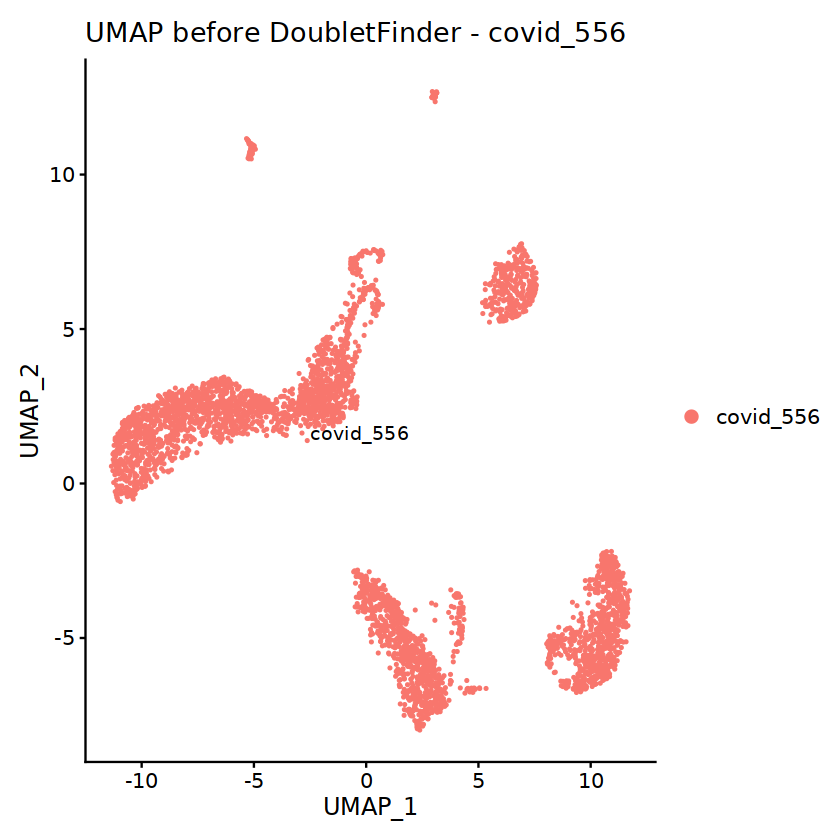

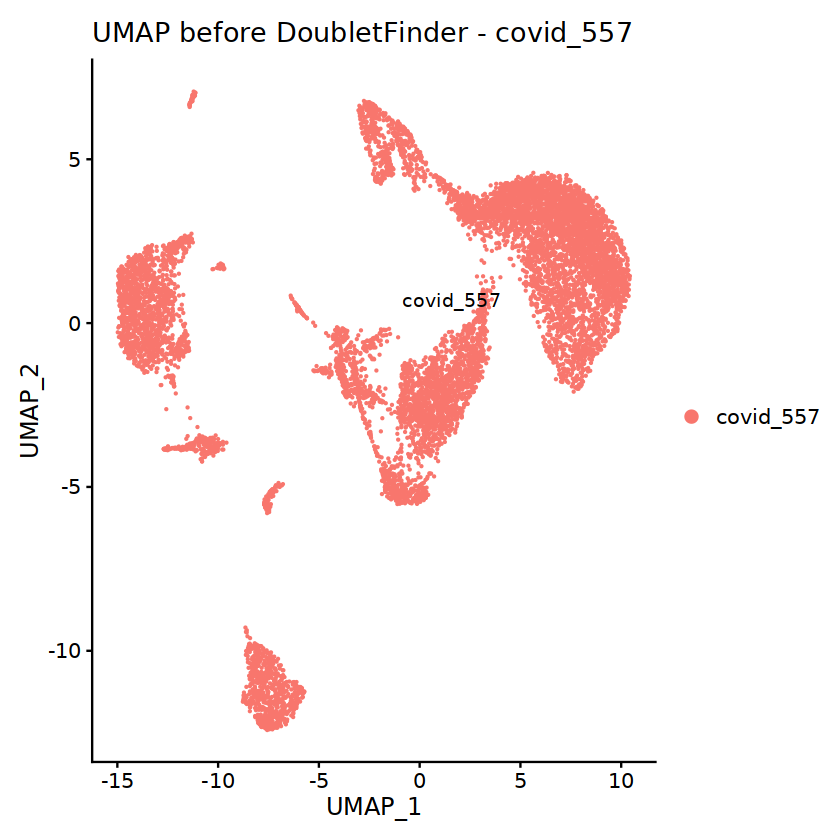

[[1]]

[[2]]

[[3]]

[[4]]


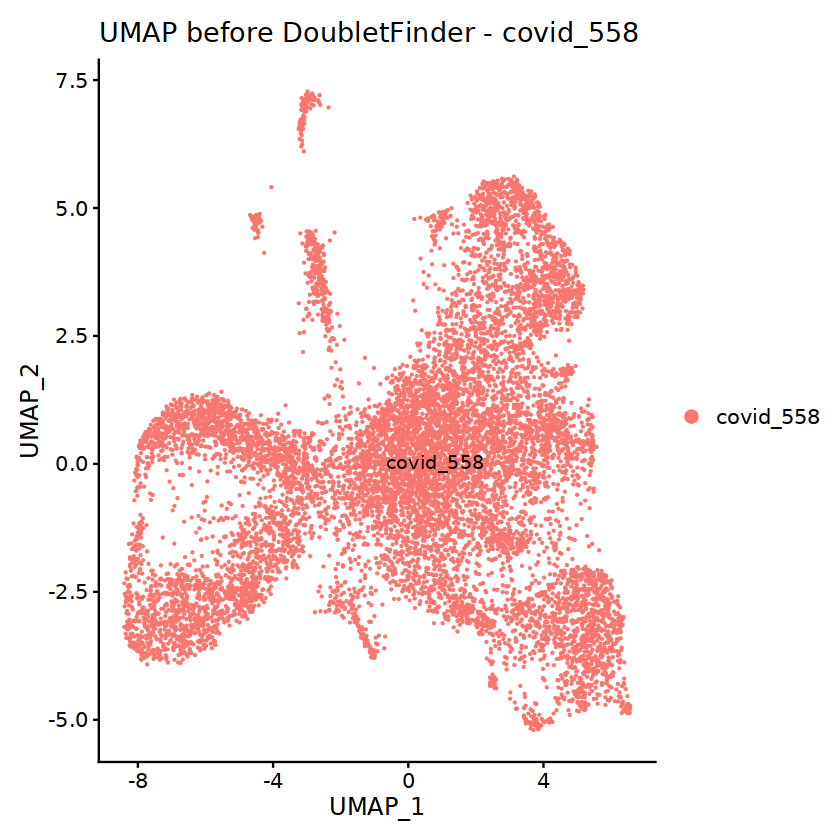

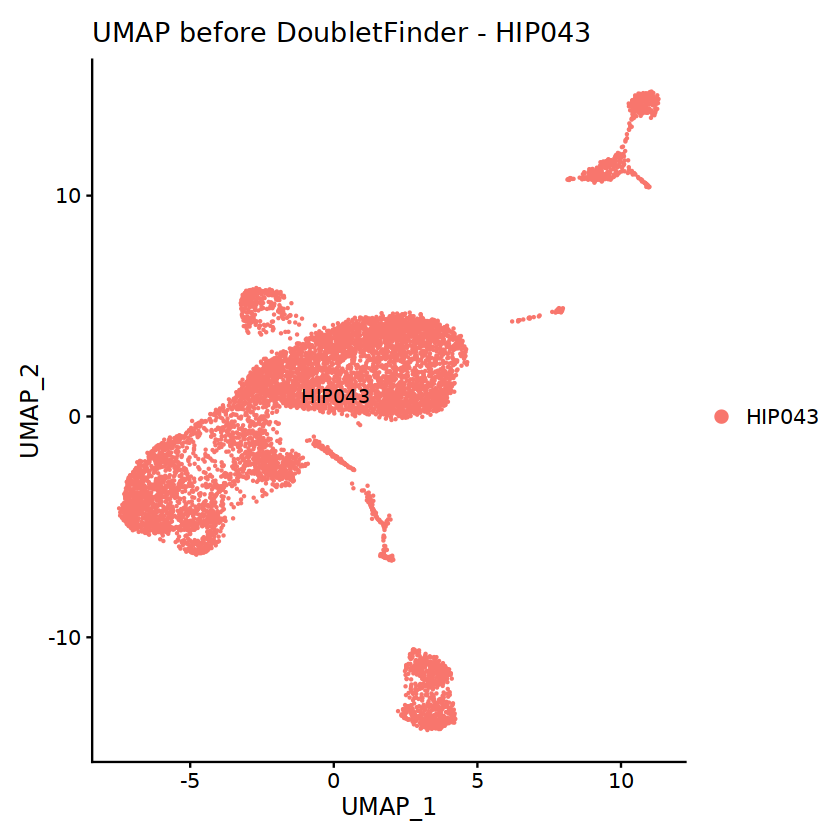

In [27]:
lapply(names(sc_data_preprocessed), function(sid) {
  obj <- sc_data_preprocessed[[sid]]
  p <- DimPlot(obj, reduction = "umap", label = TRUE) + 
       ggtitle(paste("UMAP before DoubletFinder -", sid))
})

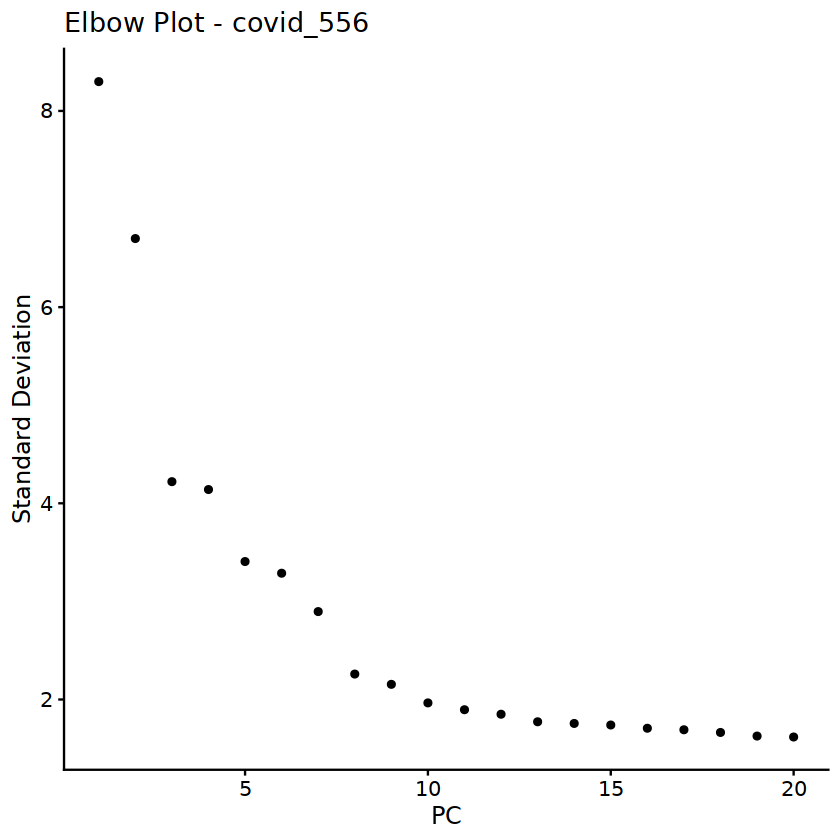

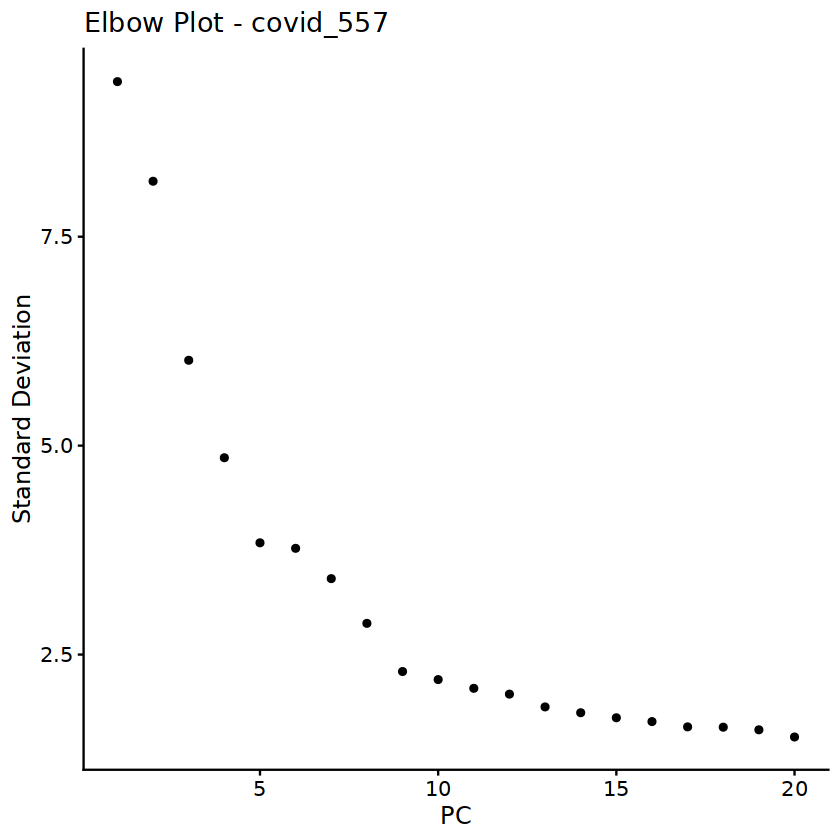

[[1]]

[[2]]

[[3]]

[[4]]


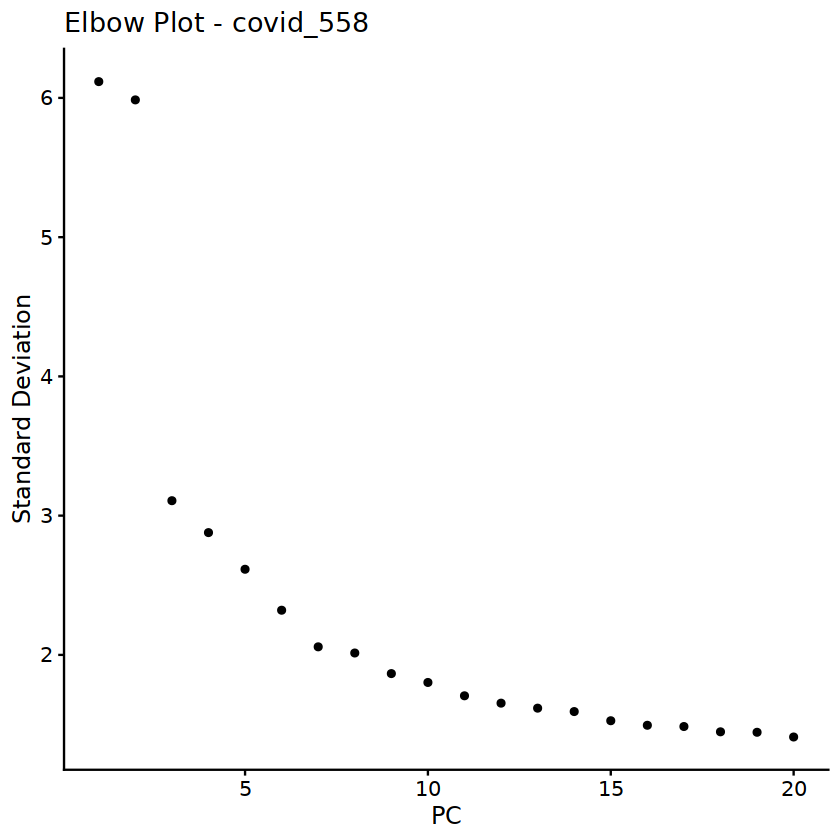

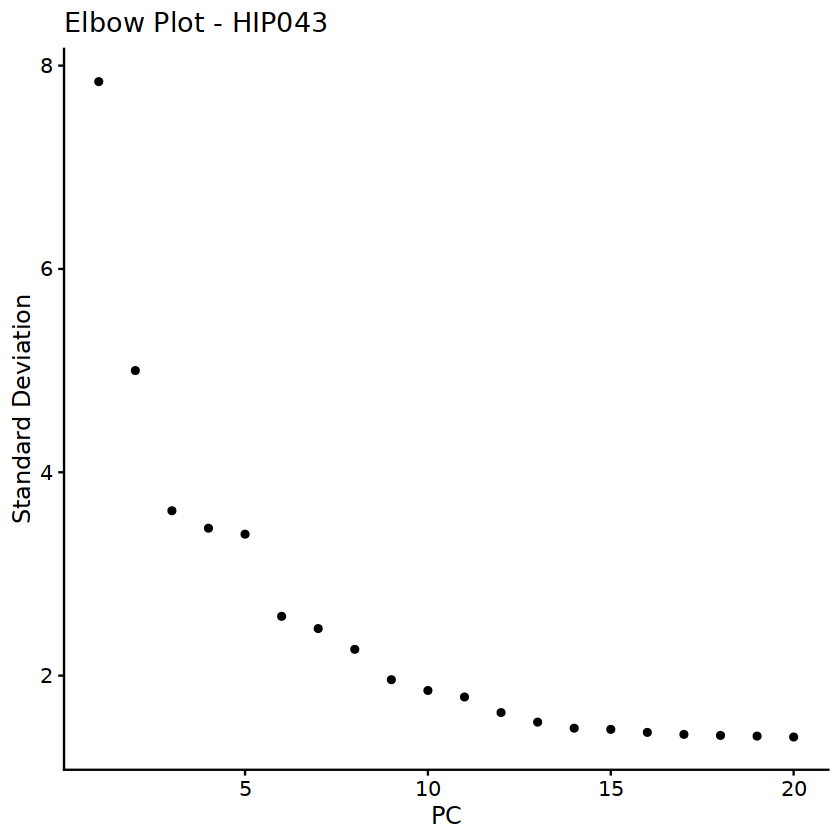

In [28]:
lapply(names(sc_data_preprocessed), function(sid) {
  obj <- sc_data_preprocessed[[sid]]
  p <- ElbowPlot(obj) + ggtitle(paste("Elbow Plot -", sid))
})


#### The elbow plot shows 10 features, which are uniform in all samples, making it a good choice for PK evaluation for doublet detection. We carry out the following analysis for the full implementation of doublet detection and removal:

- Estimating the optimal pK (neighborhood size) for each sample.

- Running paramSweep_v3, find.pK, and DoubletFinder_v3.

- Visualizing doublet vs singlet cells.

- Removing doublets and saving cleaned data.

#### Estimating the optimal PK

# Select one preprocessed sample
sample_id <- "covid_557"
obj <- sc_data_preprocessed[[sample_id]]

# Run the parameter sweep
sweep_res <- paramSweep_v3(obj, PCs = 1:10, sct = FALSE)

# Summarize results
sweep_stats <- summarizeSweep(sweep_res, GT = FALSE)

# Identify the best pK
best_pK <- find.pK(sweep_stats)
head(best_pK)

samples <- names(sc_data_preprocessed)

for (sid in samples) {
  message("Estimating pK for: ", sid)
  
  # Load single object
  obj <- sc_data_preprocessed[[sid]]
  
  # Run pK estimation
  sweep_res <- paramSweep_v3(obj, PCs = 1:10, sct = FALSE)
  sweep_stats <- summarizeSweep(sweep_res, GT = FALSE)
  best_pK <- find.pK(sweep_stats)
  
  # Extract best pK
  opt_pK <- best_pK[which.max(best_pK$BCmetric), "pK"]
  
  # Save just the result (not the object)
  saveRDS(best_pK, file = paste0("results/", sid, "_pK_results.rds"))
  write.csv(best_pK, file = paste0("results/", sid, "_pK_summary.csv"), row.names = FALSE)
  
  message("Done with ", sid, " - optimal pK: ", opt_pK, "\n")
  
  # Force R to clear memory
  rm(obj, sweep_res, sweep_stats, best_pK)
  gc()
}


In [29]:
input_dir <- "results/preprocessed_objects"
output_dir <- "results/pK_estimation"
dir.create(output_dir, showWarnings = FALSE)

# 📦 List preprocessed samples
sample_files <- list.files(input_dir, pattern = "_preprocessed\\.rds$", full.names = TRUE)
sample_names <- gsub("_preprocessed\\.rds$", "", basename(sample_files))

# 🧠 Custom lightweight function to process each sample
estimate_pK <- function(sample_file, sample_name) {
  message("\n========== Processing ", sample_name, " ==========\n")
  
  # Load only one sample into memory
  obj <- readRDS(sample_file)
  
  # ✅ Run pK parameter sweep (reduced range for speed)
  sweep_res <- paramSweep_v3(obj, PCs = 1:20, sct = FALSE, pK = seq(0.005, 0.1, by = 0.005))
  
  # ✅ Summarize and extract pK stats
  sweep_stats <- summarizeSweep(sweep_res, GT = FALSE)
  best_pK <- find.pK(sweep_stats)
  
  # ✅ Find optimal pK (highest BCmetric)
  opt_pK <- best_pK[which.max(best_pK$BCmetric), "pK"]
  message("✅ Optimal pK for ", sample_name, ": ", opt_pK, "\n")
  
  # ✅ Save full results
  saveRDS(best_pK, file = file.path(output_dir, paste0(sample_name, "_pK_results.rds")))
  write.csv(best_pK, file = file.path(output_dir, paste0(sample_name, "_pK_summary.csv")), row.names = FALSE)
  
  # ✅ Save a quick visual diagnostic plot
  png(file.path(output_dir, paste0(sample_name, "_pK_plot.png")), width = 800, height = 600)
  plot(as.numeric(as.character(best_pK$pK)), best_pK$BCmetric,
       type = "b", pch = 19, col = "blue",
       xlab = "pK", ylab = "BCmetric",
       main = paste("pK Optimization -", sample_name))
  dev.off()
  
  # ✅ Free memory before next sample
  rm(obj, sweep_res, sweep_stats, best_pK)
  gc()
  
  # Return summary info
  return(data.frame(Sample = sample_name, Optimal_pK = opt_pK))
}

# 🚀 Run safely sample by sample
pK_summary <- do.call(rbind, lapply(seq_along(sample_files), function(i) {
  estimate_pK(sample_files[i], sample_names[i])
}))

# 🧾 Save final summary table
write.csv(pK_summary, file = file.path(output_dir, "all_samples_pK_summary.csv"), row.names = FALSE)

message("\n✅ All samples processed successfully!")
message("Summary saved in: ", file.path(output_dir, "all_samples_pK_summary.csv"))


✅ All samples processed successfully!

Summary saved in: results/pK_estimation/all_samples_pK_summary.csv



pK_results <- lapply(names(sc_data_preprocessed), function(sid) {
  message("Estimating pK for ", sid, " ...")
  obj <- sc_data_preprocessed[[sid]]
  sweep_res <- paramSweep_v3(obj, PCs = 1:10, sct = FALSE)
  sweep_stats <- summarizeSweep(sweep_res, GT = FALSE)
  best_pK <- find.pK(sweep_stats)
  
  # Extract best pK (max BCmetric)
  opt_pK <- best_pK[which.max(best_pK$BCmetric), "pK"]
  data.frame(Sample = sid, Optimal_pK = opt_pK)
})

pK_df <- do.call(rbind, pK_results)
print(pK_df)


In [30]:
plot(as.numeric(as.character(best_pK$pK)), best_pK$BCmetric,
     type = "b", pch = 19, col = "blue",
     xlab = "pK", ylab = "BCmetric",
     main = paste("pK Optimization -", sample_id))


ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'plot': object 'best_pK' not found


### PK for coved_556 is 0.002. i will restart the kernel to check PK for 557